# Example 14: RVT SRA with multiple motions and simulated profiles

Example with multiple input motions and simulated soil profiles.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pystrata

%matplotlib inline

In [ ]:
# Increased figure sizes
plt.rcParams["figure.dpi"] = 120

## Create a point source theory RVT motion

In [ ]:
motions = [
    pystrata.motion.SourceTheoryRvtMotion(5.0, 30, "wna"),
    pystrata.motion.SourceTheoryRvtMotion(6.0, 30, "wna"),
    pystrata.motion.SourceTheoryRvtMotion(7.0, 30, "wna"),
]

for m in motions:
    m.calc_fourier_amps()

## Create site profile

This is about the simplest profile that we can create. Linear-elastic soil and rock.

In [ ]:
profile = pystrata.site.Profile(
    [
        pystrata.site.Layer(
            pystrata.site.DarendeliSoilType(18.0, plas_index=0, ocr=1, stress_mean=100),
            10,
            400,
        ),
        pystrata.site.Layer(
            pystrata.site.DarendeliSoilType(18.0, plas_index=0, ocr=1, stress_mean=200),
            10,
            450,
        ),
        pystrata.site.Layer(
            pystrata.site.DarendeliSoilType(18.0, plas_index=0, ocr=1, stress_mean=400),
            30,
            600,
        ),
        pystrata.site.Layer(pystrata.site.SoilType("Rock", 24.0, None, 0.01), 0, 1200),
    ]
)

## Create the site response calculator

In [ ]:
calc = pystrata.propagation.EquivalentLinearCalculator()

## Initialize the variations

In [ ]:
var_thickness = pystrata.variation.ToroThicknessVariation()
var_velocity = pystrata.variation.DepthDependToroVelVariation.generic_model("USGS C")
var_soiltypes = pystrata.variation.SpidVariation(
    -0.5, std_mod_reduc=0.15, std_damping=0.30
)

## Specify the output

In [ ]:
freqs = np.logspace(-1, 2, num=500)

outputs = pystrata.output.OutputCollection(
    [
        pystrata.output.ResponseSpectrumOutput(
            # Frequency
            freqs,
            # Location of the output
            pystrata.output.OutputLocation("outcrop", index=0),
            # Damping
            0.05,
        ),
        pystrata.output.ResponseSpectrumRatioOutput(
            # Frequency
            freqs,
            # Location in (denominator),
            pystrata.output.OutputLocation("outcrop", index=-1),
            # Location out (numerator)
            pystrata.output.OutputLocation("outcrop", index=0),
            # Damping
            0.05,
        ),
        pystrata.output.InitialVelProfile(),
        pystrata.output.MaxAccelProfile(),
    ]
)

## Perform the calculation

In [ ]:
count = 20
outputs.reset()
for i, p in enumerate(
    pystrata.variation.iter_varied_profiles(
        profile,
        count,
        # var_thickness=var_thickness,
        var_velocity=var_velocity,
        # var_soiltypes=var_soiltypes
    )
):
    # Here we auto-descretize the profile for wave propagation purposes
    p = p.auto_discretize()
    for j, m in enumerate(motions):
        name = (f"p{i}", f"m{j}")
        calc(m, p, p.location("outcrop", index=-1))
        outputs(calc, name=name)

## Plot the outputs

Create a few plots of the output.

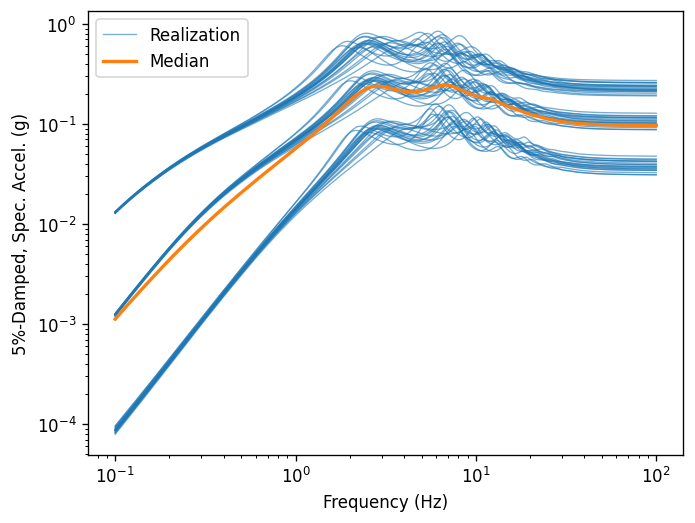

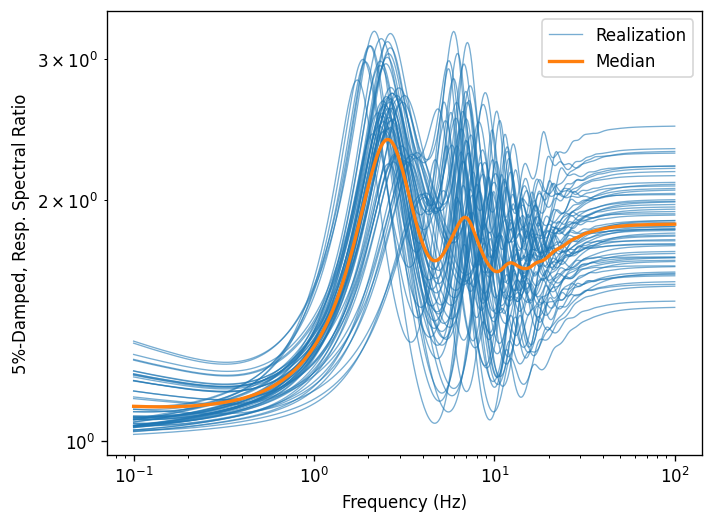

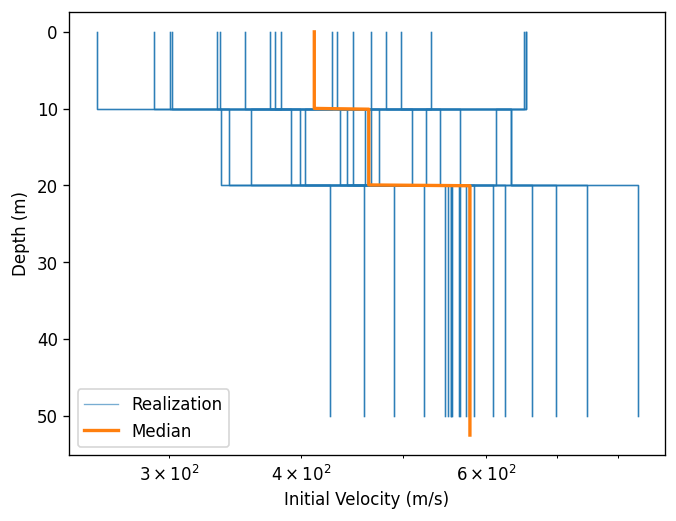

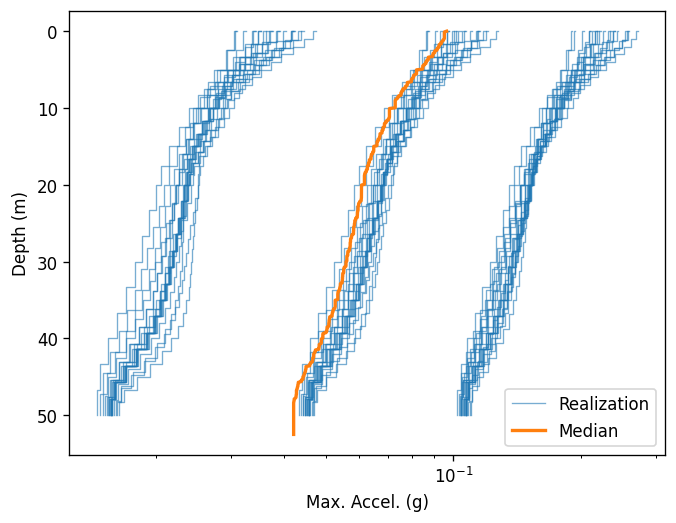

In [ ]:
for o in outputs:
    ax = o.plot(style="stats")

## Manipulating output as dataframe

If a `tuple` is passed as the output name, it is used to create a `pandas.MultiIndex` columns.

In [ ]:
df = outputs[1].to_dataframe()
df

p0                            p1                      \
                  m0        m1        m2        m0        m1        m2   
0.100000    1.262055  1.087801  1.055993  1.190523  1.063929  1.039639   
0.101394    1.261103  1.087719  1.056413  1.189854  1.063883  1.039948   
0.102807    1.260153  1.087642  1.056838  1.189187  1.063841  1.040261   
0.104240    1.259207  1.087572  1.057266  1.188523  1.063804  1.040577   
0.105693    1.258265  1.087507  1.057699  1.187862  1.063773  1.040896   
...              ...       ...       ...       ...       ...       ...   
94.613238   2.189957  2.066683  1.884675  1.693159  1.650874  1.560793   
95.932095   2.190056  2.066783  1.884802  1.693253  1.650961  1.560891   
97.269336   2.190152  2.066880  1.884924  1.693344  1.651045  1.560986   
98.625218   2.190245  2.066974  1.885043  1.693432  1.651126  1.561078   
100.000000  2.190335  2.067065  1.885158  1.693518  1.651206  1.561168   

                  p2                            p3  ...       p16       p17  \
                  m0        m1        m2        m0  ...        m2        m0   
0.100000    1.264868  1.088639  1.056706  1.208399  ...  1.027506  1.210490   
0.101394    1.263903  1.088557  1.057132  1.207719  ...  1.027728  1.209694   
0.102807    1.262942  1.088480  1.057562  1.207041  ...  1.027953  1.208901   
0.104240    1.261984  1.088409  1.057996  1.206366  ...  1.028179  1.208111   
0.105693    1.261030  1.088344  1.058434  1.205694  ...  1.028409  1.207324   
...              ...       ...       ...       ...  ...       ...       ...   
94.613238   2.317955  2.169924  1.988443  2.288159  ...  1.853102  1.614871   
95.932095   2.318045  2.170018  1.988569  2.288222  ...  1.853129  1.614956   
97.269336   2.318132  2.170109  1.988691  2.288283  ...  1.853156  1.615038   
98.625218   2.318216  2.170197  1.988810  2.288343  ...  1.853182  1.615117   
100.000000  2.318298  2.170282  1.988925  2.288400  ...  1.853207  1.615195   

                                     p18                           p19  \
                  m1        m2        m0        m1        m2        m0   
0.100000    1.069688  1.042854  1.096115  1.032283  1.019404  1.155118   
0.101394    1.069630  1.043187  1.095873  1.032279  1.019564  1.154599   
0.102807    1.069578  1.043523  1.095633  1.032277  1.019726  1.154082   
0.104240    1.069530  1.043863  1.095393  1.032279  1.019890  1.153567   
0.105693    1.069489  1.044206  1.095154  1.032283  1.020055  1.153054   
...              ...       ...       ...       ...       ...       ...   
94.613238   1.581004  1.468329  1.778538  1.697563  1.654844  1.608286   
95.932095   1.581088  1.468424  1.778548  1.697560  1.654850  1.608347   
97.269336   1.581169  1.468516  1.778557  1.697558  1.654855  1.608405   
98.625218   1.581248  1.468605  1.778565  1.697555  1.654861  1.608462   
100.000000  1.581325  1.468691  1.778574  1.697553  1.654866  1.608518   

                                
                  m1        m2  
0.100000    1.052256  1.032023  
0.101394    1.052225  1.032278  
0.102807    1.052199  1.032535  
0.104240    1.052178  1.032795  
0.105693    1.052161  1.033057  
...              ...       ...  
94.613238   1.569304  1.495007  
95.932095   1.569358  1.495071  
97.269336   1.569411  1.495134  
98.625218   1.569462  1.495194  
100.000000  1.569512  1.495253  

[500 rows x 60 columns]

Lets names to the dataframe and transform into a long format. Pandas works better on long formatted tables.

In [ ]:
# Add names for clarity
df.columns.names = ("profile", "motion")
df.index.name = "freq"
# Transform into a long format
df = df.melt(ignore_index=False).reset_index().set_index(["freq", "profile", "motion"])
df

,,,value
freq,profile,motion,
0.100000,p0,m0,1.262055
0.101394,p0,m0,1.261103
0.102807,p0,m0,1.260153
0.104240,p0,m0,1.259207
0.105693,p0,m0,1.258265
...,...,...,...
94.613238,p19,m2,1.495007
95.932095,p19,m2,1.495071
97.269336,p19,m2,1.495134


In [ ]:
def calc_stats(group):
    ln_value = np.log(group["value"])

    median = np.exp(np.mean(ln_value))
    ln_std = np.std(ln_value)

    return pd.Series({"median": median, "ln_std": ln_std})


stats = df.groupby(level=["freq", "motion"]).apply(calc_stats)
stats

median    ln_std
freq       motion                    
0.100000   m0      1.208622  0.049392
           m1      1.069940  0.017648
           m2      1.043773  0.011707
0.101394   m0      1.207892  0.049192
           m1      1.069884  0.017621
...                     ...       ...
98.625218  m1      1.878328  0.104661
           m2      1.752719  0.095676
100.000000 m0      1.972164  0.118234
           m1      1.878389  0.104663
           m2      1.752798  0.095678

[1500 rows x 2 columns]

In [ ]:
stats = (
    stats.reset_index("motion")
    .pivot(columns="motion")
    .swaplevel(0, 1, axis=1)
    .sort_index(axis=1)
)
stats

motion            m0                  m1                  m2          
              ln_std    median    ln_std    median    ln_std    median
freq                                                                  
0.100000    0.049392  1.208622  0.017648  1.069940  0.011707  1.043773
0.101394    0.049192  1.207892  0.017621  1.069884  0.011784  1.044109
0.102807    0.048991  1.207165  0.017596  1.069834  0.011863  1.044448
0.104240    0.048792  1.206440  0.017570  1.069788  0.011942  1.044791
0.105693    0.048592  1.205719  0.017546  1.069749  0.012022  1.045138
...              ...       ...       ...       ...       ...       ...
94.613238   0.118236  1.971901  0.104655  1.878135  0.095671  1.752468
95.932095   0.118236  1.971970  0.104657  1.878202  0.095672  1.752555
97.269336   0.118235  1.972037  0.104659  1.878266  0.095674  1.752638
98.625218   0.118235  1.972102  0.104661  1.878328  0.095676  1.752719
100.000000  0.118234  1.972164  0.104663  1.878389  0.095678  1.752798

[500 rows x 6 columns]

Access the properties of each motion like:

In [ ]:
stats["m0"]

,ln_std,median
freq,,
0.100000,0.049392,1.208622
0.101394,0.049192,1.207892
0.102807,0.048991,1.207165
0.104240,0.048792,1.206440
0.105693,0.048592,1.205719
...,...,...
94.613238,0.118236,1.971901
95.932095,0.118236,1.971970
97.269336,0.118235,1.972037


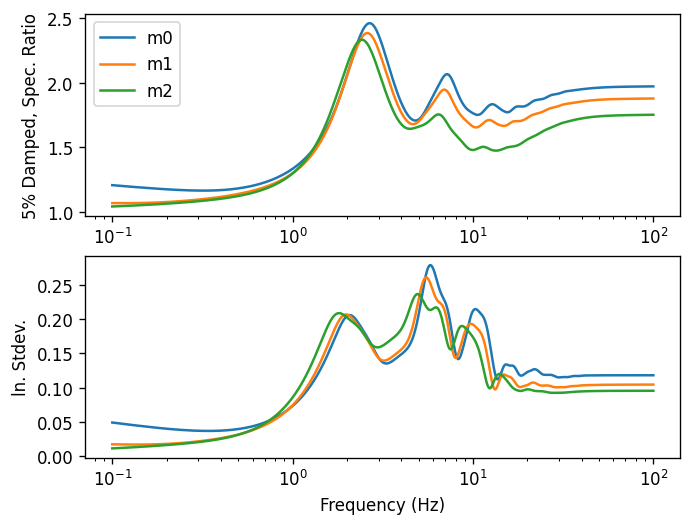

In [ ]:
fig, axes = plt.subplots(nrows=2, subplot_kw={"xscale": "log"})

for name, g in stats.T.groupby(level=0):
    for ax, key in zip(axes, ["median", "ln_std"]):
        ax.plot(g.columns, g.loc[name, key], label=name)


axes[0].set(ylabel="5% Damped, Spec. Ratio")
axes[0].legend()

axes[1].set(ylabel="ln. Stdev.", xlabel="Frequency (Hz)")

fig;